# Neural Style Transfer with Deep Convlotional Neural Networks
In this notebook, we’ll *recreate* a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch. This is one of the first method to do style transfer. 


In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. Conv_1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv_2_1 is the first convolutional layer in the second stack. The deepest convolutional layer in the network is conv_5_4.



In [0]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

## Loading the model
VGG19 has two parts. The first part consists of convolutional layers and the second part is two fully connected layers and it acts as a classifier. Here we just want to get the feature maps produced by the convolutional layers so we will load the first part only.


The model will be loaded from torchvision pre-trained models. Also, we will freeze the parameters of the convolutional layers because we don't want them to be changed and we are only changing the target image. 

In [13]:
# loading the first part
vgg = models.vgg19(pretrained=True).features

# freezing the parameters
for param in vgg.parameters():
    param.requires_grad_(False)
    
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

## Loading image
`load_image` is a helper function. It will load the image from `img_path` path and then preprocess the image. We process the image because the model accepts a specific format for its input.

This function will do certain steps: 


1- Load the image from `img_path` path. We will use `Image.open` from Pillow library. After that, we convert it to `RGB` photo using `convert`. 


2- We put a threshold for the size of the image using `max_size` function argument. Big images will slow processing. So if our image size is bigger than the `max_size` then we will crop it.


3- We will use `transform` object to preprocess the image. it will do three operations. First, it will resize the image size to `size`. Then, it will convert this image into a tensor. Finally, it will normalize the produced tensor (The first parameter is a tuple of means for every channel and the second parameter is the corresponding standard deviations.). 


4- Finally, we will discard the alpha channel and add one dimension for the batch number.  


In [0]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Then we will load content and style images. Make sure to pass a correct path for your image. Because the two images can be different in their size, we will resize the style image to match the content image.

In [0]:
# load in content and style image

# Here you must write the path of your content image
content_image_path = 'content.jpg' 

content = load_image(content_image_path).to(device)

# Here you must write the path of your style image
style_image_path = 'style.jpg'

# Resize style to match content.
style = load_image(style_image_path, shape=content.shape[-2:]).to(device)

## Getting features
The function `get_feature` will return the features maps produced by the layers in `layers` dictionary. These feature maps are used to calculate the losses. The layers of the model are indexed using numbers. `layers` is a dictionary that maps between the index of a given layer and its name. Here we will use the layers that are mentioned in the paper. Then we feedforward the image through the layers. We store the feature maps of every layer in `layers` dictionary in a new dictionary `features`. Then we return this dictionary.

In [0]:
def get_features(image, model, layers=None):

    # The layers that are mentioned in Gatys et al (2016) paper
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                 '10': 'conv3_1',
                 '19': 'conv4_1',
                 '21': 'conv4_2',
                 '28' : 'conv5_1'}

    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

## The Gram matrix
The output of every convolutional layer is a Tensor with dimensions associated with the batch_size, a depth, d and some height and width (h, w). The Gram matrix of a convolutional layer can be calculated as follows:


1- Get the depth, height, and width of a tensor using `tensor.shape`. 


2- Reshape that tensor so that the spatial dimensions are flattened. We wil use `view` function to reshape the Tensor. 


3- Calculate the gram matrix by multiplying the reshaped tensor by it's transpose. `torch.mm` is used to multiply the two tensors. 

In [0]:
def gram_matrix(tensor):
  
    ## reshape it, so we're multiplying the features for each channel
    tensor = tensor.view(tensor.shape[1], tensor.shape[2]*tensor.shape[3])
    
    # calculate the gram matrix
    gram = torch.mm(tensor,tensor.t())
    
    return gram 

## Getting features for style and content images 
Now we will extract features from our images and calculate the Gram matrix for each layer in our style representation. Also, we create a copy from our content image and assign it to our target image. 

In [0]:
# get content and style features
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Initalizing our target image
target = content.clone().requires_grad_(True).to(device)

## Dispaly an image
This is a helper function. It will un-normalize an image and convert it from a Tensor image to a NumPy image for displaying it.

In [0]:
def im_convert(tensor):
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

## Weights 
We have two kinds of weights:

1- Style representation weights. You can put weights for the layers that are used to calculate the Gram matrix. 

2- Style and content loss weights. We use the value that are mentioned in the paper. This ratio will affect the stylization of the final image. It's recommended that you leave the content_weight = 1 and set the style_weight to achieve the ratio you want.

In [0]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

content_weight = 1  # alpha
style_weight = 1e6  # beta

## Update the Target image
Now it is time to change the target image. Using content and style features that we generated we will change the target image. The steps of doing that are: 


1- Determine our hyperparameters. Our optimizer will be `Adam`. Then we will determine the number of steps (how many iterations we update the target image). 

2- Getting the target features using `get_features`. 

3- Calculate the content loss. which is defined as the mean square difference between the target and content features at layer `conv4_2`.



                            content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)



4- Calculate the style loss. We iterate through each style layer. Then, we get the corresponding target features from `target features`. After that, we calculate the Gram matrix for the target features. The style loss for one layer is the mean square difference between the Gram matrices. Finally, we add the loss of the current layer to the total loss. We normalize the loss by dividing by (d X w X h). 

5- Calculate the total loss. The total loss will be the weighted sum of the content and style losses. 

6- Update the target image by back-propagating the loss `total_loss.backward()` and doing one optimizer step.

7- Display the loss and the intermediate images every `show_every` steps.

Total loss:  91860232.0


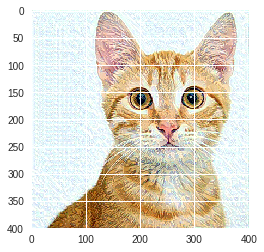

Total loss:  42610660.0


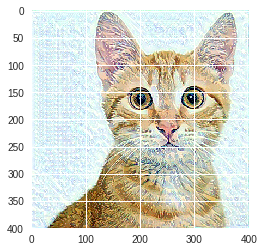

Total loss:  23225108.0


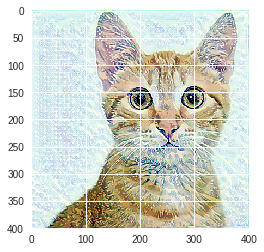

Total loss:  91860232.0


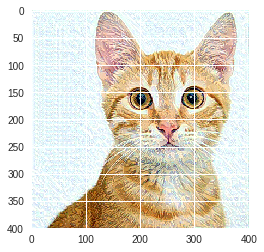

Total loss:  42610660.0


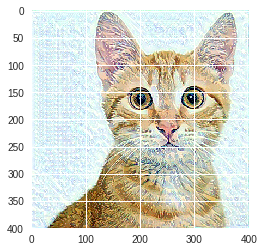

Total loss:  23225108.0


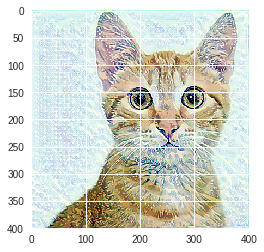

Total loss:  13834075.0
Total loss:  13834075.0


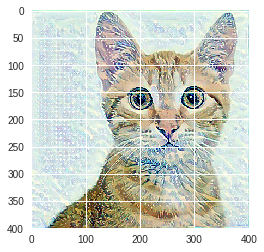

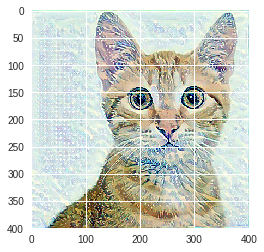

Total loss:  8659680.0
Total loss:  8659680.0


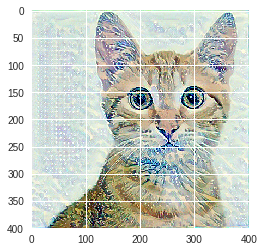

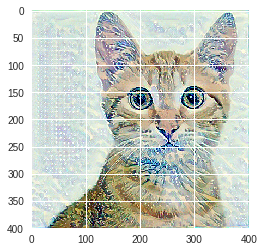

In [21]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image    
    target_features = get_features(target, vgg)
    
    # calculate the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # initialize the style loss to 0
    style_loss = 0
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
      
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        # Calculate the target gram matrix
        target_gram = gram_matrix(target_feature)
        
        # get the "style" style representation
        style_gram = style_grams[layer]
        
        # Calculate the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer]* torch.mean((target_gram - style_gram)**2)
        
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
        
    # calculate the *total* loss
    total_loss = content_weight*content_loss + style_weight*style_loss

    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

### Displaying the final result

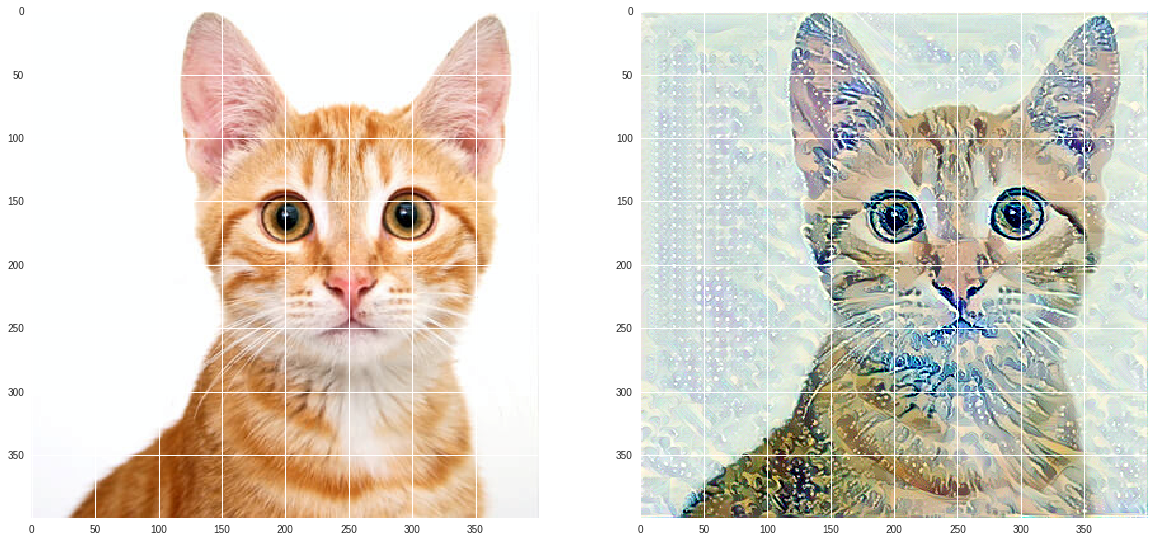

In [27]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

<Figure size 432x288 with 0 Axes>